# Train and EDA

## Solution:
### The data is very noisy and unbalanced. Columns containing more than 50% of the missing values were removed, with NaN's. Replaced 0 values on mode for each column, deleted oultiers, apply log transform for skewed data. Noticed that there is a correlation, but removing it worsens the results (mauby I overfitted).
### Split data with train_test_split (.2), baseline - LogisticRegression, also tried XGBClassifier, Lightgbm and RandomForest. XGBClassifier and RandomForest showed good results. Choosing with PyCaret determined XGBClassifier the best model. So I choose XGBClassifier (with GPU) based on results.

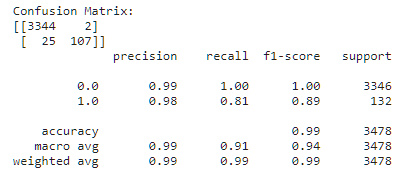

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import scipy
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import optuna
from sklearn.impute import SimpleImputer

pd.set_option("display.max_columns", None)

In [2]:
df_train = pd.read_csv("/kaggle/input/privat-bank-ds/train_df.csv", sep="\t")

In [3]:
df_train.columns

Index(['Unnamed: 0', 'num_1', 'num_2', 'num_3', 'num_4', 'num_5', 'num_6',
       'num_7', 'cat_1', 'num_8',
       ...
       'num_413', 'cat_132', 'cat_133', 'num_414', 'num_415', 'num_416',
       'cat_134', 'cat_135', 'id', 'gb'],
      dtype='object', length=554)

In [4]:
df_train.shape

(26824, 554)

In [5]:
df_train.head()

,Unnamed: 0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_1,num_8,num_9,num_10,num_11,num_12,num_13,num_14,num_15,num_16,num_17,num_18,num_19,num_20,num_21,num_22,num_23,cat_2,num_24,cat_3,cat_4,num_25,num_26,num_27,cat_5,num_28,num_29,cat_6,cat_7,cat_8,num_30,cat_9,cat_10,num_31,num_32,num_33,num_34,num_35,num_36,num_37,num_38,num_39,num_40,num_41,cat_11,cat_12,num_42,cat_13,num_43,num_44,num_45,cat_14,cat_15,num_46,num_47,num_48,num_49,num_50,num_51,num_52,num_53,num_54,cat_16,num_55,num_56,num_57,cat_17,num_58,cat_18,num_59,num_60,num_61,num_62,num_63,num_64,num_65,cat_19,num_66,num_67,num_68,num_69,num_70,num_71,cat_20,num_72,num_73,num_74,num_75,num_76,cat_21,num_77,num_78,cat_22,num_79,cat_23,cat_24,num_80,num_81,cat_25,num_82,cat_26,cat_27,cat_28,num_83,num_84,num_85,cat_29,num_86,num_87,num_88,num_89,num_90,cat_30,num_91,cat_31,cat_32,num_92,num_93,num_94,num_95,num_96,num_97,num_98,num_99,num_100,num_101,cat_33,num_102,num_103,num_104,num_105,num_106,num_107,num_108,num_109,num_110,num_111,num_112,cat_34,num_113,num_114,num_115,cat_35,num_116,num_117,num_118,num_119,cat_36,num_120,cat_37,num_121,num_122,cat_38,cat_39,num_123,num_124,num_125,num_126,num_127,num_128,num_129,num_130,num_131,num_132,num_133,num_134,cat_40,cat_41,cat_42,num_135,cat_43,num_136,num_137,num_138,num_139,cat_44,cat_45,cat_46,num_140,num_141,cat_47,num_142,num_143,num_144,cat_48,cat_49,cat_50,num_145,num_146,num_147,num_148,num_149,num_150,cat_51,num_151,cat_52,num_152,cat_53,num_153,num_154,num_155,num_156,num_157,cat_54,num_158,num_159,num_160,num_161,num_162,num_163,num_164,num_165,num_166,num_167,num_168,cat_55,num_169,num_170,num_171,num_172,num_173,cat_56,num_174,num_175,num_176,num_177,num_178,num_179,num_180,num_181,num_182,num_183,num_184,cat_57,num_185,cat_58,num_186,num_187,num_188,cat_59,cat_60,num_189,cat_61,num_190,num_191,num_192,num_193,num_194,num_195,num_196,num_197,num_198,cat_62,num_199,num_200,num_201,cat_63,num_202,cat_64,cat_65,cat_66,num_203,num_204,num_205,num_206,num_207,num_208,cat_67,cat_68,num_209,num_210,cat_69,cat_70,num_211,cat_71,num_212,num_213,num_214,num_215,num_216,num_217,num_218,num_219,num_220,num_221,num_222,num_223,num_224,num_225,cat_72,cat_73,num_226,num_227,num_228,cat_74,num_229,num_230,num_231,num_232,cat_75,num_233,num_234,cat_76,num_235,cat_77,num_236,num_237,num_238,cat_78,num_239,cat_79,num_240,num_241,num_242,cat_80,num_243,num_244,cat_81,cat_82,num_245,cat_83,num_246,num_247,num_248,num_249,num_250,num_251,num_252,num_253,num_254,num_255,num_256,cat_84,cat_85,num_257,cat_86,num_258,num_259,cat_87,cat_88,num_260,num_261,num_262,cat_89,num_263,cat_90,cat_91,cat_92,num_264,num_265,num_266,num_267,num_268,num_269,num_270,num_271,cat_93,num_272,num_273,num_274,cat_94,cat_95,num_275,cat_96,num_276,num_277,num_278,num_279,cat_97,num_280,num_281,num_282,num_283,num_284,num_285,num_286,num_287,num_288,num_289,num_290,num_291,num_292,cat_98,num_293,num_294,num_295,num_296,cat_99,cat_100,num_297,num_298,num_299,num_300,num_301,cat_101,cat_102,num_302,cat_103,num_303,num_304,cat_104,cat_105,num_305,num_306,num_307,num_308,num_309,num_310,num_311,num_312,num_313,num_314,cat_106,num_315,cat_107,num_316,cat_108,num_317,num_318,num_319,num_320,num_321,num_322,num_323,num_324,num_325,num_326,cat_109,cat_110,num_327,num_328,cat_111,cat_112,num_329,num_330,num_331,num_332,num_333,num_334,num_335,num_336,num_337,num_338,num_339,num_340,num_341,num_342,cat_113,num_343,num_344,num_345,cat_114,num_346,num_347,num_348,cat_115,num_349,cat_116,cat_117,num_350,cat_118,num_351,num_352,num_353,num_354,num_355,num_356,num_357,num_358,num_359,num_360,num_361,num_362,num_363,num_364,num_365,num_366,num_367,cat_119,num_368,cat_120,num_369,num_370,num_371,num_372,num_373,num_374,num_375,cat_121,num_376,num_377,num_378,num_379,num_380,num_381,num_382,num_383,num_384,num_385,num_386,cat_122,num_387,cat_123,cat_124,num_388,num_389,num_390,num_391,cat_125,num_392,num_393,cat_126,cat_127,cat_128,cat_129,num_394,num_395,num_396,num_

In [6]:
df_test = pd.read_csv("/kaggle/input/privat-bank-ds/delay_df.csv", sep="\t")

In [7]:
df_test.shape

(9922, 553)

In [8]:
df_test.head()

,Unnamed: 0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_1,num_8,num_9,num_10,num_11,num_12,num_13,num_14,num_15,num_16,num_17,num_18,num_19,num_20,num_21,num_22,num_23,cat_2,num_24,cat_3,cat_4,num_25,num_26,num_27,cat_5,num_28,num_29,cat_6,cat_7,cat_8,num_30,cat_9,cat_10,num_31,num_32,num_33,num_34,num_35,num_36,num_37,num_38,num_39,num_40,num_41,cat_11,cat_12,num_42,cat_13,num_43,num_44,num_45,cat_14,cat_15,num_46,num_47,num_48,num_49,num_50,num_51,num_52,num_53,num_54,cat_16,num_55,num_56,num_57,cat_17,num_58,cat_18,num_59,num_60,num_61,num_62,num_63,num_64,num_65,cat_19,num_66,num_67,num_68,num_69,num_70,num_71,cat_20,num_72,num_73,num_74,num_75,num_76,cat_21,num_77,num_78,cat_22,num_79,cat_23,cat_24,num_80,num_81,cat_25,num_82,cat_26,cat_27,cat_28,num_83,num_84,num_85,cat_29,num_86,num_87,num_88,num_89,num_90,cat_30,num_91,cat_31,cat_32,num_92,num_93,num_94,num_95,num_96,num_97,num_98,num_99,num_100,num_101,cat_33,num_102,num_103,num_104,num_105,num_106,num_107,num_108,num_109,num_110,num_111,num_112,cat_34,num_113,num_114,num_115,cat_35,num_116,num_117,num_118,num_119,cat_36,num_120,cat_37,num_121,num_122,cat_38,cat_39,num_123,num_124,num_125,num_126,num_127,num_128,num_129,num_130,num_131,num_132,num_133,num_134,cat_40,cat_41,cat_42,num_135,cat_43,num_136,num_137,num_138,num_139,cat_44,cat_45,cat_46,num_140,num_141,cat_47,num_142,num_143,num_144,cat_48,cat_49,cat_50,num_145,num_146,num_147,num_148,num_149,num_150,cat_51,num_151,cat_52,num_152,cat_53,num_153,num_154,num_155,num_156,num_157,cat_54,num_158,num_159,num_160,num_161,num_162,num_163,num_164,num_165,num_166,num_167,num_168,cat_55,num_169,num_170,num_171,num_172,num_173,cat_56,num_174,num_175,num_176,num_177,num_178,num_179,num_180,num_181,num_182,num_183,num_184,cat_57,num_185,cat_58,num_186,num_187,num_188,cat_59,cat_60,num_189,cat_61,num_190,num_191,num_192,num_193,num_194,num_195,num_196,num_197,num_198,cat_62,num_199,num_200,num_201,cat_63,num_202,cat_64,cat_65,cat_66,num_203,num_204,num_205,num_206,num_207,num_208,cat_67,cat_68,num_209,num_210,cat_69,cat_70,num_211,cat_71,num_212,num_213,num_214,num_215,num_216,num_217,num_218,num_219,num_220,num_221,num_222,num_223,num_224,num_225,cat_72,cat_73,num_226,num_227,num_228,cat_74,num_229,num_230,num_231,num_232,cat_75,num_233,num_234,cat_76,num_235,cat_77,num_236,num_237,num_238,cat_78,num_239,cat_79,num_240,num_241,num_242,cat_80,num_243,num_244,cat_81,cat_82,num_245,cat_83,num_246,num_247,num_248,num_249,num_250,num_251,num_252,num_253,num_254,num_255,num_256,cat_84,cat_85,num_257,cat_86,num_258,num_259,cat_87,cat_88,num_260,num_261,num_262,cat_89,num_263,cat_90,cat_91,cat_92,num_264,num_265,num_266,num_267,num_268,num_269,num_270,num_271,cat_93,num_272,num_273,num_274,cat_94,cat_95,num_275,cat_96,num_276,num_277,num_278,num_279,cat_97,num_280,num_281,num_282,num_283,num_284,num_285,num_286,num_287,num_288,num_289,num_290,num_291,num_292,cat_98,num_293,num_294,num_295,num_296,cat_99,cat_100,num_297,num_298,num_299,num_300,num_301,cat_101,cat_102,num_302,cat_103,num_303,num_304,cat_104,cat_105,num_305,num_306,num_307,num_308,num_309,num_310,num_311,num_312,num_313,num_314,cat_106,num_315,cat_107,num_316,cat_108,num_317,num_318,num_319,num_320,num_321,num_322,num_323,num_324,num_325,num_326,cat_109,cat_110,num_327,num_328,cat_111,cat_112,num_329,num_330,num_331,num_332,num_333,num_334,num_335,num_336,num_337,num_338,num_339,num_340,num_341,num_342,cat_113,num_343,num_344,num_345,cat_114,num_346,num_347,num_348,cat_115,num_349,cat_116,cat_117,num_350,cat_118,num_351,num_352,num_353,num_354,num_355,num_356,num_357,num_358,num_359,num_360,num_361,num_362,num_363,num_364,num_365,num_366,num_367,cat_119,num_368,cat_120,num_369,num_370,num_371,num_372,num_373,num_374,num_375,cat_121,num_376,num_377,num_378,num_379,num_380,num_381,num_382,num_383,num_384,num_385,num_386,cat_122,num_387,cat_123,cat_124,num_388,num_389,num_390,num_391,cat_125,num_392,num_393,cat_126,cat_127,cat_128,cat_129,num_394,num_395,num_396,num_

In [9]:
numeric_features = [col for col in df_train.columns if col.startswith('num_')]
cat_features = [col for col in df_train.columns if col.startswith('cat_')]

In [10]:
# How many types in data and their count
df_train.dtypes.value_counts()

float64    416
int64      138
dtype: int64

## We have only 2 data types: float and int

In [11]:
import pandas as pd


repetitive_cols = []
for column in df_train[cat_features]:
    value_counts = df_train[column].value_counts()
    if value_counts.iloc[0] > len(df_train) * 0.9:  # Set a threshold for repetition, e.g., if more than 90% of the values are the same
        repetitive_cols.append(column)

cleaned_df = df_train.drop(repetitive_cols, axis=1)
print(len(repetitive_cols))


75


In [12]:
cleaned_df.shape

(26824, 479)

In [13]:
# Calculate summary statistics for numerical columns
numerical_columns = numeric_features
numerical_stats = cleaned_df[numerical_columns].describe()


# Set a threshold for column sparsity
variance_threshold = 0.01  # Columns with variance below this threshold will be considered sparse


sparse_numerical_columns = [col for col in numerical_columns if numerical_stats.loc['std', col] < variance_threshold]

# Combine the sparse column names
sparse_columns = sparse_numerical_columns# + sparse_categorical_columns


# Drop the sparse columns from the DataFrame
df = cleaned_df.drop(columns=sparse_columns)

In [14]:
df.shape

(26824, 475)

### This is slow, but you will see histograms

In [15]:
# # Get summary statistics for all columns
# stats = df_train.describe()

# # Plot histograms for all columns
# df_train.hist(figsize=(20, 40), bins=30)
# plt.tight_layout()
# plt.show()

# # Optional: Visualize correlation matrix
# corr_matrix = df_train.corr()
# plt.figure(figsize=(12, 10))
# plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
# plt.colorbar()
# plt.title('Correlation Matrix')
# plt.xticks(range(len(df_train.columns)), df_train.columns, rotation=90)
# plt.yticks(range(len(df_train.columns)), df_train.columns)
# plt.tight_layout()
# plt.show()


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26824 entries, 0 to 26823
Columns: 554 entries, Unnamed: 0 to gb
dtypes: float64(416), int64(138)
memory usage: 113.4 MB


In [17]:
df_train.describe()

,Unnamed: 0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_1,num_8,num_9,num_10,num_11,num_12,num_13,num_14,num_15,num_16,num_17,num_18,num_19,num_20,num_21,num_22,num_23,cat_2,num_24,cat_3,cat_4,num_25,num_26,num_27,cat_5,num_28,num_29,cat_6,cat_7,cat_8,num_30,cat_9,cat_10,num_31,num_32,num_33,num_34,num_35,num_36,num_37,num_38,num_39,num_40,num_41,cat_11,cat_12,num_42,cat_13,num_43,num_44,num_45,cat_14,cat_15,num_46,num_47,num_48,num_49,num_50,num_51,num_52,num_53,num_54,cat_16,num_55,num_56,num_57,cat_17,num_58,cat_18,num_59,num_60,num_61,num_62,num_63,num_64,num_65,cat_19,num_66,num_67,num_68,num_69,num_70,num_71,cat_20,num_72,num_73,num_74,num_75,num_76,cat_21,num_77,num_78,cat_22,num_79,cat_23,cat_24,num_80,num_81,cat_25,num_82,cat_26,cat_27,cat_28,num_83,num_84,num_85,cat_29,num_86,num_87,num_88,num_89,num_90,cat_30,num_91,cat_31,cat_32,num_92,num_93,num_94,num_95,num_96,num_97,num_98,num_99,num_100,num_101,cat_33,num_102,num_103,num_104,num_105,num_106,num_107,num_108,num_109,num_110,num_111,num_112,cat_34,num_113,num_114,num_115,cat_35,num_116,num_117,num_118,num_119,cat_36,num_120,cat_37,num_121,num_122,cat_38,cat_39,num_123,num_124,num_125,num_126,num_127,num_128,num_129,num_130,num_131,num_132,num_133,num_134,cat_40,cat_41,cat_42,num_135,cat_43,num_136,num_137,num_138,num_139,cat_44,cat_45,cat_46,num_140,num_141,cat_47,num_142,num_143,num_144,cat_48,cat_49,cat_50,num_145,num_146,num_147,num_148,num_149,num_150,cat_51,num_151,cat_52,num_152,cat_53,num_153,num_154,num_155,num_156,num_157,cat_54,num_158,num_159,num_160,num_161,num_162,num_163,num_164,num_165,num_166,num_167,num_168,cat_55,num_169,num_170,num_171,num_172,num_173,cat_56,num_174,num_175,num_176,num_177,num_178,num_179,num_180,num_181,num_182,num_183,num_184,cat_57,num_185,cat_58,num_186,num_187,num_188,cat_59,cat_60,num_189,cat_61,num_190,num_191,num_192,num_193,num_194,num_195,num_196,num_197,num_198,cat_62,num_199,num_200,num_201,cat_63,num_202,cat_64,cat_65,cat_66,num_203,num_204,num_205,num_206,num_207,num_208,cat_67,cat_68,num_209,num_210,cat_69,cat_70,num_211,cat_71,num_212,num_213,num_214,num_215,num_216,num_217,num_218,num_219,num_220,num_221,num_222,num_223,num_224,num_225,cat_72,cat_73,num_226,num_227,num_228,cat_74,num_229,num_230,num_231,num_232,cat_75,num_233,num_234,cat_76,num_235,cat_77,num_236,num_237,num_238,cat_78,num_239,cat_79,num_240,num_241,num_242,cat_80,num_243,num_244,cat_81,cat_82,num_245,cat_83,num_246,num_247,num_248,num_249,num_250,num_251,num_252,num_253,num_254,num_255,num_256,cat_84,cat_85,num_257,cat_86,num_258,num_259,cat_87,cat_88,num_260,num_261,num_262,cat_89,num_263,cat_90,cat_91,cat_92,num_264,num_265,num_266,num_267,num_268,num_269,num_270,num_271,cat_93,num_272,num_273,num_274,cat_94,cat_95,num_275,cat_96,num_276,num_277,num_278,num_279,cat_97,num_280,num_281,num_282,num_283,num_284,num_285,num_286,num_287,num_288,num_289,num_290,num_291,num_292,cat_98,num_293,num_294,num_295,num_296,cat_99,cat_100,num_297,num_298,num_299,num_300,num_301,cat_101,cat_102,num_302,cat_103,num_303,num_304,cat_104,cat_105,num_305,num_306,num_307,num_308,num_309,num_310,num_311,num_312,num_313,num_314,cat_106,num_315,cat_107,num_316,cat_108,num_317,num_318,num_319,num_320,num_321,num_322,num_323,num_324,num_325,num_326,cat_109,cat_110,num_327,num_328,cat_111,cat_112,num_329,num_330,num_331,num_332,num_333,num_334,num_335,num_336,num_337,num_338,num_339,num_340,num_341,num_342,cat_113,num_343,num_344,num_345,cat_114,num_346,num_347,num_348,cat_115,num_349,cat_116,cat_117,num_350,cat_118,num_351,num_352,num_353,num_354,num_355,num_356,num_357,num_358,num_359,num_360,num_361,num_362,num_363,num_364,num_365,num_366,num_367,cat_119,num_368,cat_120,num_369,num_370,num_371,num_372,num_373,num_374,num_375,cat_121,num_376,num_377,num_378,num_379,num_380,num_381,num_382,num_383,num_384,num_385,num_386,cat_122,num_387,cat_123,cat_124,num_388,num_389,num_390,num_391,cat_125,num_392,num_393,cat_126,cat_127,cat_128,cat_129,num_394,num_395,num_396,num_

## we can see that many columns contain NaN's

### The column "Unnamed: 0" is typically an artifact of data storage or reading processes and does not contain any meaningful information. It is often automatically generated when saving or reading data without explicitly specifying a column name for the index

In [18]:
# Delete columns with NaN's values

columns_with_all_nan = df_train.columns[df_train.isna().all()]
df_train = df_train.drop(columns=columns_with_all_nan)
df_train = df_train.drop(columns=["Unnamed: 0", "id"])
print(columns_with_all_nan)


Index(['num_23', 'num_66', 'num_150', 'num_152', 'num_242', 'num_250',
       'num_258', 'num_266', 'num_342', 'num_365', 'num_375', 'num_392'],
      dtype='object')


In [19]:
df_train.shape

(26824, 540)

### We have a lot of missing values

In [20]:
df_train.isna().sum()

num_1       3796
num_2       3871
num_3      26761
num_4          8
num_5       9615
           ...  
num_415        8
num_416        8
cat_134        0
cat_135        0
gb             0
Length: 540, dtype: int64

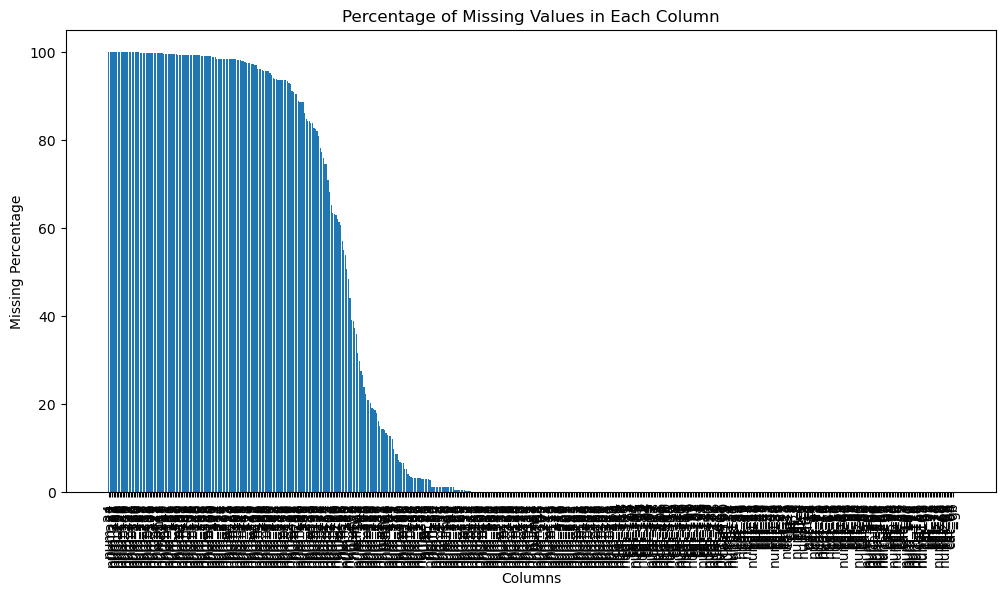

In [21]:
# Calculate the percentage of missing values for each column
missing_percentages = df_train.isnull().sum() / len(df_train) * 100

# Sort the columns based on the percentage of missing values in descending order
missing_percentages_sorted = missing_percentages.sort_values(ascending=False)

# Plot a bar chart to visualize the missingness distribution
plt.figure(figsize=(12, 6))
plt.bar(missing_percentages_sorted.index, missing_percentages_sorted)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Missing Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [22]:
(missing_percentages>50).sum()

153

In [23]:
delete_cols = missing_percentages[missing_percentages>50].index

In [24]:
df = df_train.drop(columns=delete_cols)

In [25]:
df.shape

(26824, 387)

In [26]:
# check duplicate records
df[df.duplicated()]

,num_1,num_2,num_4,num_5,num_6,num_7,cat_1,num_8,num_9,num_10,num_13,num_14,num_15,num_19,cat_2,cat_3,cat_4,num_26,num_27,cat_5,num_28,num_29,cat_6,cat_7,cat_8,num_30,cat_9,cat_10,num_32,num_33,num_38,num_40,num_41,cat_11,cat_12,cat_13,num_43,num_45,cat_14,cat_15,num_50,num_52,num_53,num_54,cat_16,num_55,num_57,cat_17,num_58,cat_18,num_59,num_60,num_62,num_64,cat_19,num_67,num_68,num_69,num_70,num_71,cat_20,num_72,num_74,num_75,cat_21,num_77,cat_22,num_79,cat_23,cat_24,num_80,num_81,cat_25,cat_26,cat_27,cat_28,num_83,num_84,cat_29,num_87,num_88,cat_30,cat_31,cat_32,num_92,num_94,num_95,num_97,cat_33,num_102,num_104,num_105,num_107,num_110,num_111,num_112,cat_34,num_113,num_114,num_115,cat_35,num_117,num_119,cat_36,num_120,cat_37,num_122,cat_38,cat_39,num_123,num_124,num_128,num_129,num_130,num_132,num_133,num_134,cat_40,cat_41,cat_42,cat_43,num_136,num_137,num_139,cat_44,cat_45,cat_46,num_141,cat_47,num_144,cat_48,cat_49,cat_50,num_145,num_147,num_148,cat_51,num_151,cat_52,cat_53,num_154,num_155,cat_54,num_158,num_159,num_161,num_162,num_164,num_165,num_167,num_168,cat_55,num_169,num_172,num_173,cat_56,num_174,num_175,num_176,num_177,num_178,num_179,num_180,num_181,num_183,num_184,cat_57,num_185,cat_58,num_186,num_187,num_188,cat_59,cat_60,cat_61,num_191,num_193,num_194,num_196,num_197,cat_62,num_200,num_201,cat_63,num_202,cat_64,cat_65,cat_66,num_203,num_205,num_206,cat_67,cat_68,num_209,cat_69,cat_70,num_211,cat_71,num_212,num_213,num_214,num_216,num_218,num_219,num_220,num_225,cat_72,cat_73,num_228,cat_74,num_230,num_231,num_232,cat_75,num_233,num_234,cat_76,num_235,cat_77,num_237,num_238,cat_78,num_239,cat_79,num_240,cat_80,num_244,cat_81,cat_82,cat_83,num_246,num_252,num_255,cat_84,cat_85,cat_86,num_259,cat_87,cat_88,num_260,num_262,cat_89,num_263,cat_90,cat_91,cat_92,num_264,num_265,num_267,num_268,num_269,num_270,cat_93,cat_94,cat_95,num_275,cat_96,num_276,num_277,cat_97,num_282,num_283,num_284,num_285,num_287,num_288,num_289,num_290,num_292,cat_98,num_294,num_296,cat_99,cat_100,num_298,num_299,num_301,cat_101,cat_102,cat_103,num_303,num_304,cat_104,cat_105,num_305,num_306,num_307,num_309,num_311,num_312,num_313,num_314,cat_106,num_315,cat_107,cat_108,num_317,num_318,num_319,num_320,num_321,cat_109,cat_110,num_327,cat_111,cat_112,num_330,num_331,num_332,num_338,num_339,num_340,num_341,cat_113,num_344,num_345,cat_114,num_346,num_347,cat_115,cat_116,cat_117,num_350,cat_118,num_351,num_352,num_353,num_354,num_355,num_357,num_358,num_359,num_360,num_361,num_364,num_366,num_367,cat_119,cat_120,num_370,num_371,num_372,num_373,cat_121,num_378,num_379,num_380,num_381,num_382,num_384,num_385,cat_122,num_387,cat_123,cat_124,num_389,cat_125,num_393,cat_126,cat_127,cat_128,cat_129,num_395,num_396,cat_130,num_398,num_400,cat_131,num_402,num_404,num_405,num_406,num_407,num_408,num_409,num_410,num_411,num_412,num_413,cat_132,cat_133,num_414,num_415,num_416,cat_134,cat_135,gb


### Haven't duplicates in dataset

In [27]:
df.shape

(26824, 387)

In [28]:
df.isna().sum().sum()

220047

### Impute missing values

In [29]:
imputer = SimpleImputer(strategy='mean')  # You can choose different strategies: 'mean', 'median', 'most_frequent', or 'constant'

imputer.fit(df)

# Transform and replace missing values
df = pd.DataFrame(imputer.transform(df), columns=df.columns)


In [30]:
df.isna().sum().sum()

0

## Check if dataset don't contain constant values

In [31]:
# check constat values

def check_constant_values(dataset):
    previous_value = None
    for value in dataset:
        if previous_value is not None and value != previous_value:
            return False
        previous_value = value
    return True

# Example usage

result = check_constant_values(df)
print(result)

False


In [32]:
df.isna().sum().sum()

0

In [33]:
df_filtered = df

### This technice delete almost full dataset

In [34]:
# def remove_columns_with_outliers_iqr(df, columns):
#     columns_to_remove = []
#     for column in columns:
#         if column in df.columns:
#             # Calculate IQR
#             Q1 = df[column].quantile(0.25)
#             Q3 = df[column].quantile(0.75)
#             IQR = Q3 - Q1

#             # Define the lower and upper bounds for outliers
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR

#             # Check if column contains outliers
#             if any((df[column] < lower_bound) | (df[column] > upper_bound)):
#                 columns_to_remove.append(column)

#     df_filtered = df.drop(columns=columns_to_remove)
#     return df_filtered

# # Get the columns starting with 'num_'
# num_columns = [column for column in df_filtered.columns if column.startswith('num_')]

# # Remove columns with outliers using IQR
# df_filtered = remove_columns_with_outliers_iqr(df_filtered, num_columns)

In [35]:
df_filtered.shape

(26824, 387)

In [36]:
import numpy as np
from scipy import stats

def remove_outliers_zscore(df, threshold=3):
    z_scores = np.abs(stats.zscore(df))
    outlier_indices = np.where(z_scores > threshold)
    cleaned_df = df.drop(outlier_indices[0])
    return cleaned_df


# Detect outliers
outlier_indices = remove_outliers_zscore(df_filtered)

# Remove outliers
df_filtered = df_filtered.drop(outlier_indices.index)


In [37]:
numeric_col_name = [column for column in df_filtered.columns if column.startswith('num_')]

In [38]:
skew_df = pd.DataFrame(numeric_col_name, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df_filtered[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x>=0.5 else False)
#     skew_df

In [39]:
# 
skew_df["Skewed"].value_counts()

True     226
False     25
Name: Skewed, dtype: int64

In [40]:
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,num_1,27.827191,27.827191,True
1,num_2,22.209106,22.209106,True
2,num_4,-0.013827,0.013827,False
3,num_5,81.046518,81.046518,True
4,num_6,39.061085,39.061085,True
...,...,...,...,...
246,num_412,28.649244,28.649244,True
247,num_413,61.289502,61.289502,True
248,num_414,8.422146,8.422146,True
249,num_415,89.737996,89.737996,True


### Magority of columns have positive skew (right), so we'll apply log transformation (most suitable)

In [41]:
# Apply for skewed columns log transform
for colunm in skew_df.query('Skewed == True')['Feature'].values:
    negative_or_zero_mask = (df_filtered[colunm] <= 0)
    df_filtered.loc[negative_or_zero_mask, colunm] = 0
    df_filtered[colunm] = np.log1p(df_filtered[colunm])

In [42]:
df_filtered.isna().sum().sum()

0

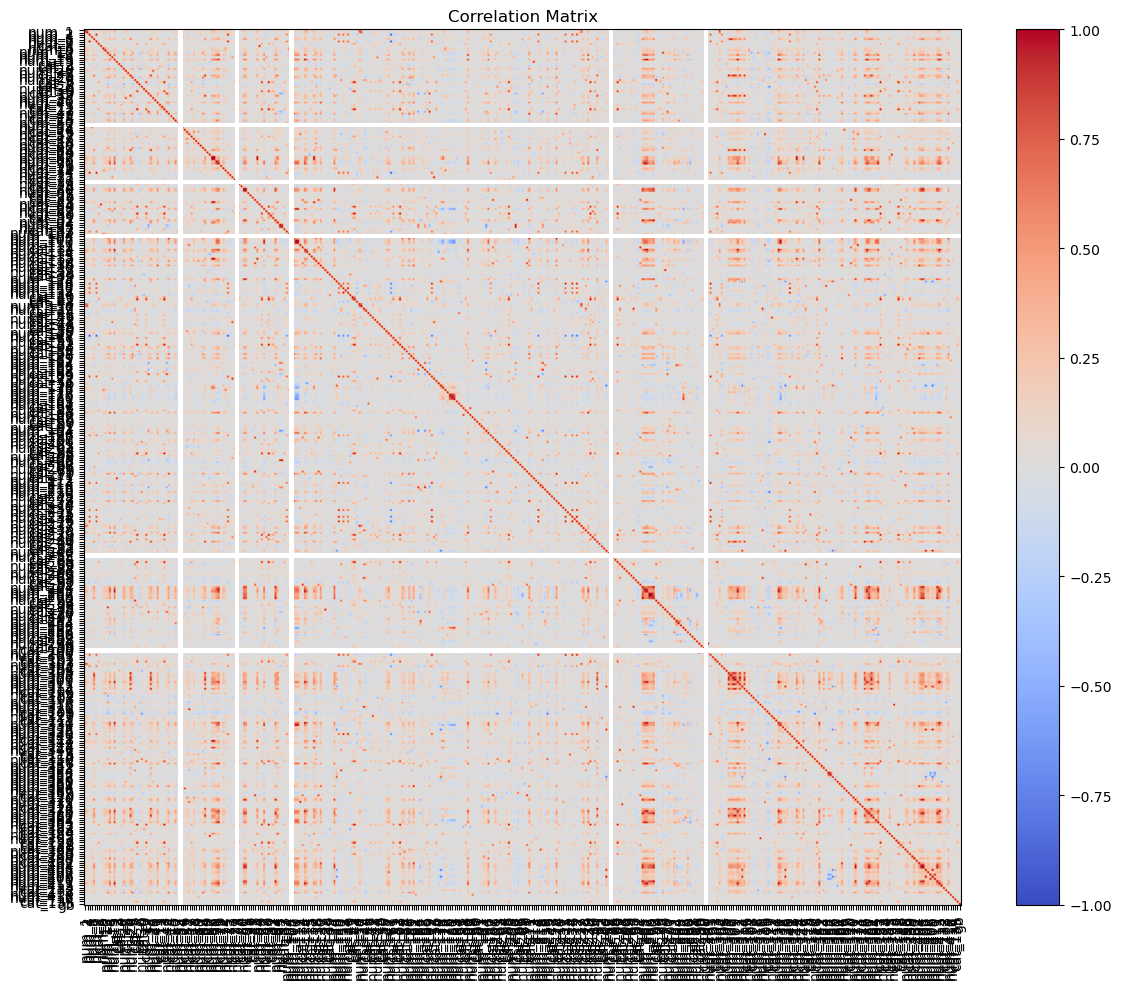

In [43]:
# Optional: Visualize correlation matrix
corr_matrix = df_filtered.corr()
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(df_filtered.columns)), df_filtered.columns, rotation=90)
plt.yticks(range(len(df_filtered.columns)), df_filtered.columns)
plt.tight_layout()
plt.show()

### If I delete correlation, results will worst

In [44]:
# correlation_matrix = df_filtered.corr()
# threshold = 0.8  # Define your correlation threshold (e.g., 0.8)

# delete_corr = []
# for i in range(len(correlation_matrix.columns)):
#     for j in range(i+1, len(correlation_matrix.columns)):
#         if abs(correlation_matrix.iloc[i, j]) > threshold:
#             col_j = correlation_matrix.columns[j]
#             delete_corr.append(col_j)

In [45]:
# df_filtered = df_filtered.drop(columns=delete_corr)

## Replace zeros by mode

In [46]:
for column in df_filtered[numeric_col_name].columns:
    non_zero_values = df_filtered[column][df_filtered[column] != 0]
    if len(non_zero_values) > 0:
        mode_value = non_zero_values.mode()[0]
        df_filtered[column] = df_filtered[column].replace(0, mode_value)

# Replace NaN (it suggests that there were no non-zero values in the respective feature, so appeared NaN's) values with 0
df_filtered = df_filtered.fillna(0)

### yes, I lose some important data (in some columns) but this 0 values spoil the distribution

#### Or you can replace by mean

In [47]:
# # df_mean = df_filtered[numeric_col_name].copy()
# for column in df_filtered[numeric_col_name].columns:
#     non_zero_values = df_filtered[column][df_filtered[column] != 0]
#     if len(non_zero_values) > 0:
#         mean_value = non_zero_values.mean()
#         df_filtered[column] = df_filtered[column].replace(0, mean_value)

# # Replace NaN (it suggests that there were no non-zero values in the respective feature, so appeared NaN's) values with 0
# df_filtered = df_filtered.fillna(0)
# # yes, I lose some important data (in some columns) but this 0 values spoil the distribution

In [48]:
df_filtered.isna().sum().sum()

0

In [49]:
X = df_filtered.drop('gb', axis=1)
y = df_filtered['gb']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline

In [51]:
model = LogisticRegression()
model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [52]:
# Make predictions on the test set
predictions = model.predict(X_test)

In [53]:
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Evaluate the model
report = classification_report(y_test, predictions)
print(report)

Confusion Matrix:
[[4387    1]
 [ 119    2]]
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      4388
         1.0       0.67      0.02      0.03       121

    accuracy                           0.97      4509
   macro avg       0.82      0.51      0.51      4509
weighted avg       0.97      0.97      0.96      4509



In [54]:
# Creating an instance of the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model on the training data
model.fit(X_train, y_train)

# Making predictions on the testing data
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Evaluating the accuracy of the model
report = classification_report(y_test, y_pred)
print(report)

Confusion Matrix:
[[4388    0]
 [  47   74]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      4388
         1.0       1.00      0.61      0.76       121

    accuracy                           0.99      4509
   macro avg       0.99      0.81      0.88      4509
weighted avg       0.99      0.99      0.99      4509



### Imbalanced classes. Ratio between class 0 (26,231 occurrences) and class 1 (593 occurrences) is approximately 44:1 - highly imbalanced

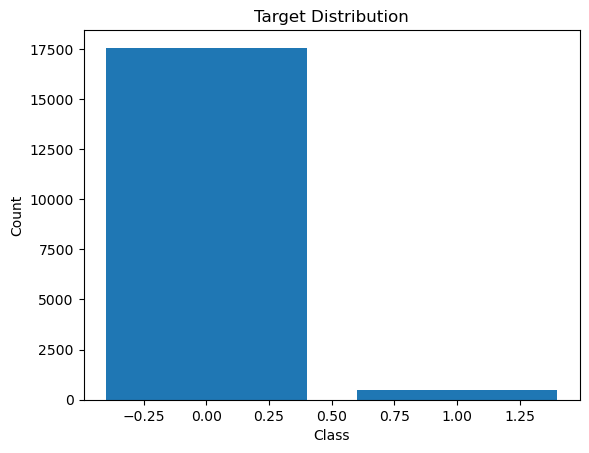

In [55]:
class_counts = y_train.value_counts()

# Create a bar plot of the target distribution
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()

In [56]:
class_counts

0.0    17560
1.0      472
Name: gb, dtype: int64

### undersumpling don't suitable for this dataset, minority class is very small

In [57]:
# Oversampling only to train data
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [58]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(X_train_sm, y_train_sm)

y_pred = random_forest.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Evaluating the accuracy of the model
report = classification_report(y_test, y_pred)
print(report)

Confusion Matrix:
[[4388    0]
 [  35   86]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4388
         1.0       1.00      0.71      0.83       121

    accuracy                           0.99      4509
   macro avg       1.00      0.86      0.91      4509
weighted avg       0.99      0.99      0.99      4509



### I use Pycaret, for choosing best model - xgboost shows best res

In [59]:
# !pip install pycaret
# from pycaret.classification import *
# numeric_features = [col for col in df_train.columns if col.startswith('num_')]
# cat_features = [col for col in df_train.columns if col.startswith('cat_')]
# clf_data = setup(df_train, target='gb', numeric_features=numeric_features, categorical_features=cat_features)
# compare_models()

In [60]:
import lightgbm as lgb

In [61]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train_sm, y_train_sm)

LGBMClassifier()

In [62]:
# predict the results
y_pred=clf.predict(X_test)

In [63]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Evaluating the accuracy of the model
report = classification_report(y_test, y_pred)
print(report)

Confusion Matrix:
[[4388    0]
 [  44   77]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4388
         1.0       1.00      0.64      0.78       121

    accuracy                           0.99      4509
   macro avg       1.00      0.82      0.89      4509
weighted avg       0.99      0.99      0.99      4509



In [64]:

# fit model no training data
xgboost = XGBClassifier(tree_method='gpu_hist',  # Specify the GPU histogram method
    gpu_id=0 )
xgboost.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [65]:
# make predictions for test data
y_pred = xgboost.predict(X_test)
predictions = [round(value) for value in y_pred]

In [66]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Evaluating the accuracy of the model
report = classification_report(y_test, y_pred)
print(report)

Confusion Matrix:
[[4386    2]
 [  31   90]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4388
         1.0       0.98      0.74      0.85       121

    accuracy                           0.99      4509
   macro avg       0.99      0.87      0.92      4509
weighted avg       0.99      0.99      0.99      4509



In [67]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



# Create the ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[('rf', random_forest), ('xgb', xgboost)],
    voting='soft'  # 'soft' for probabilities-based voting or 'hard' for majority voting
)

# Train the ensemble model
ensemble_model.fit(X_train_sm, y_train_sm)

# Make predictions using the ensemble model
predictions = ensemble_model.predict(X_test)


In [68]:
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Evaluating the accuracy of the model
report = classification_report(y_test, predictions)
print(report)

Confusion Matrix:
[[4387    1]
 [  32   89]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4388
         1.0       0.99      0.74      0.84       121

    accuracy                           0.99      4509
   macro avg       0.99      0.87      0.92      4509
weighted avg       0.99      0.99      0.99      4509



### Tried tune hyperparametrs with Optuma, but itdidn't help (had error)

In [69]:
# def objective(trial):
#     params = {
#         'tree_method': 'gpu_hist',  # Use GPU acceleration
#         'gpu_id': 0,  # Specify the GPU device index
#         'objective': 'binary:logistic',
#         'eval_metric': 'logloss',
#         'booster': 'gbtree',
#         'verbosity': 0,
#         'n_jobs': -1,
#         'seed': 42,
#         'eta': trial.suggest_loguniform('eta', 1e-5, 0.5),
#         'max_depth': trial.suggest_int('max_depth', 1, 10),
#         'subsample': trial.suggest_discrete_uniform('subsample', 0.1, 1, 0.1),
#         'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1, 0.1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#     }

#     model = XGBClassifier(**params)
#     model.fit(X_train_sm, y_train_sm)
#     y_pred = model.predict(X_test)
#     report = classification_report(y_test, y_pred)

#     return report


In [70]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=300)

In [71]:
# print('Best trial:')
# trial = study.best_trial
# print(f'  Value: {trial.value:.4f}')
# print('  Params: ')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')


### With configured parameters from GridSearch result bad

In [72]:
# # Define the best parameters
# best_params = {'colsample_bytree': 1.0,
#                'learning_rate': 0.01,
#                'max_depth': 7,
#                'n_estimators': 1000,
#                'subsample': 0.8}

# # Create an XGBoost classifier with the best parameters
# xgb_model = XGBClassifier(tree_method='gpu_hist',
#                           # Specify the GPU histogram method
#                             gpu_id=0,
#                             **best_params)

# # Train the XGBoost model
# xgb_model.fit(X_train_sm, y_train_sm)

# # Use the trained XGBoost model for predictions
# y_pred = xgb_model.predict(X_test)

### Feature importance

In [73]:
model = RandomForestRegressor()

model.fit(X_train_sm, y_train_sm)

# Retrieve feature importances
importances = model.feature_importances_

In [74]:
feature_names = df_filtered.columns

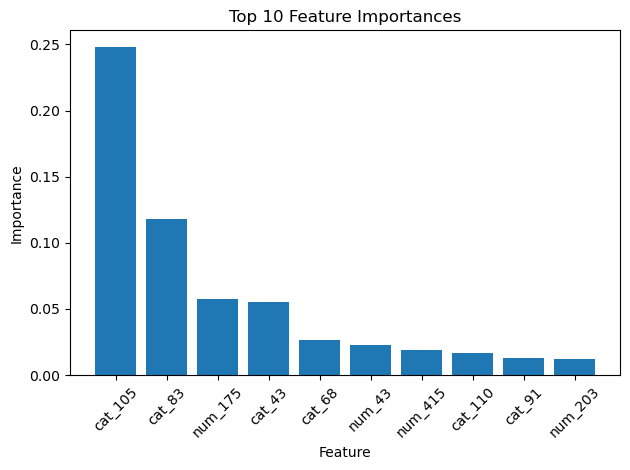

In [75]:
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

# Select the top 10 features
top_features_indices = sorted_indices[:10]
top_features_importances = sorted_importances[:10]

# Get the corresponding feature names
# feature_names = [f'num_{i}' for i in range(len(importances))]

top_feature_names = [feature_names[i] for i in top_features_indices]

# Create a bar plot
plt.bar(range(len(top_features_importances)), top_features_importances)
plt.xticks(range(len(top_features_importances)), top_feature_names, rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

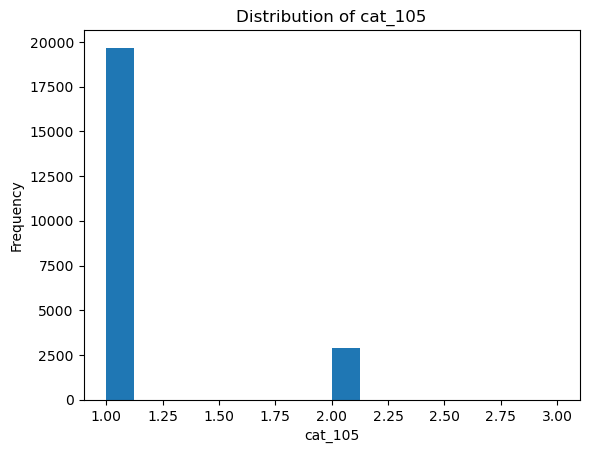

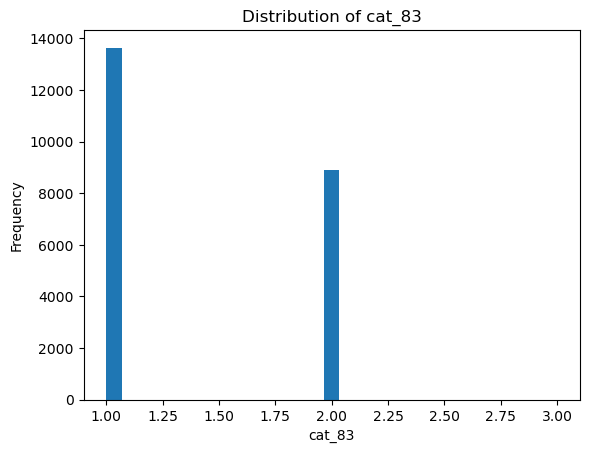

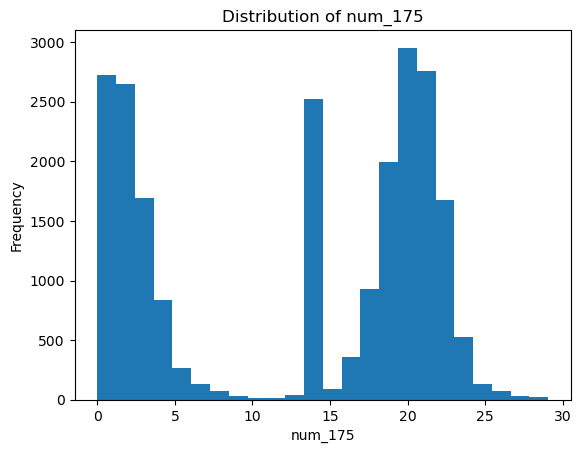

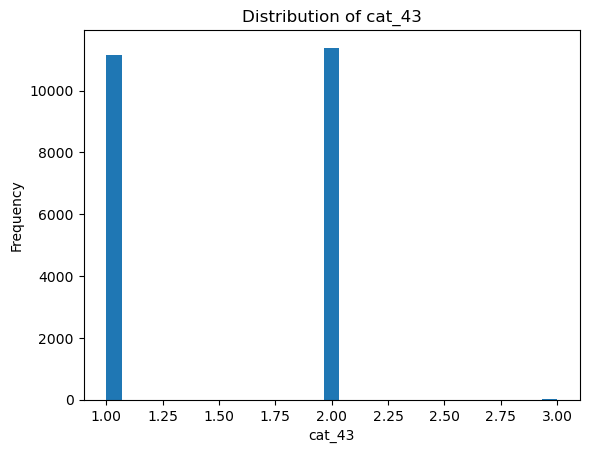

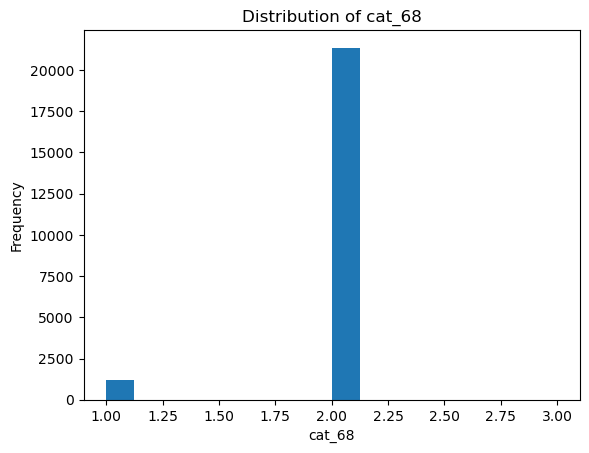

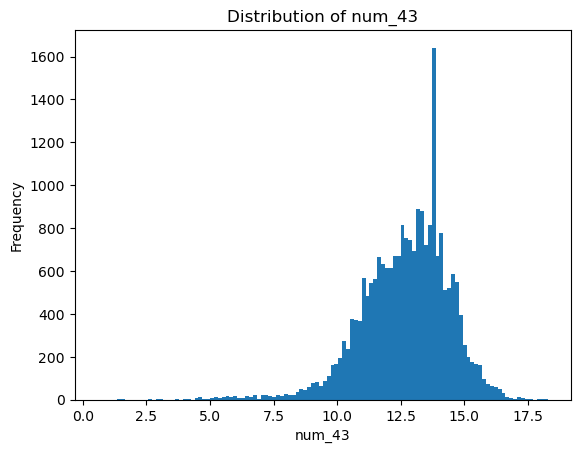

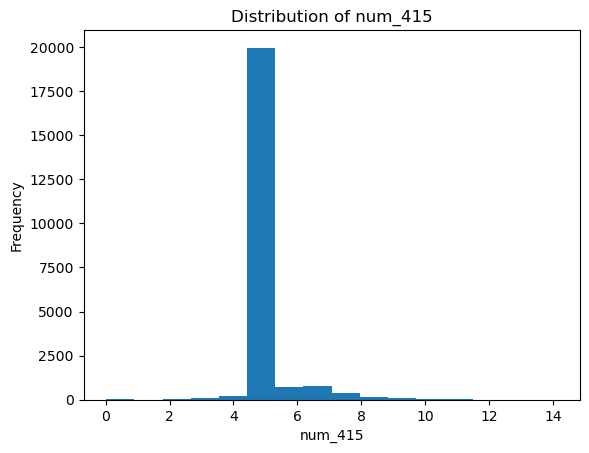

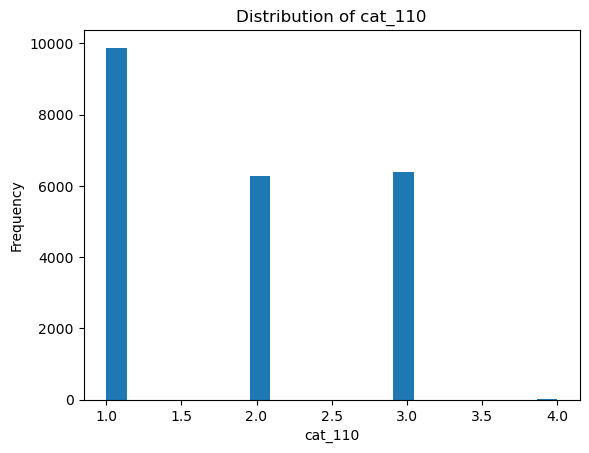

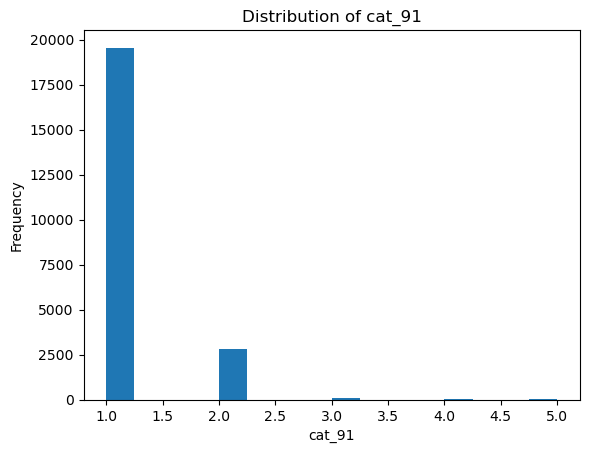

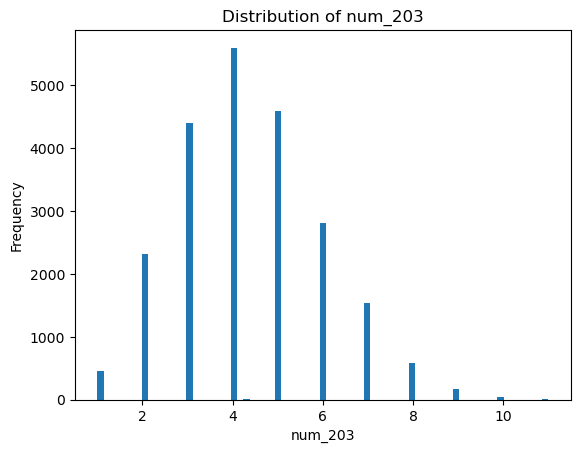

In [76]:
# Plot histograms for the top 10 features
for feature_name in top_feature_names:
    selected_feature = df_filtered[feature_name]
    plt.hist(selected_feature, bins='auto')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature_name}')
    plt.show()

#### We have zero columns

In [77]:
columns_with_majority_zero = []
zero_counts = {}

for column in X_train_sm.columns:
    value_counts = X_train_sm[column].value_counts()
    majority_value = value_counts.idxmax()
    majority_count = value_counts.max()

    if majority_value == 0:
        columns_with_majority_zero.append(column)
        zero_counts[column] = majority_count

print("Columns where the majority value is 0:")
print(columns_with_majority_zero)

print("Count of 0 values for each column:")
for column, count in zero_counts.items():
    print(f"{column}: {count}")

Columns where the majority value is 0:
['num_53', 'num_79', 'num_105', 'num_255', 'num_298']
Count of 0 values for each column:
num_53: 35120
num_79: 35120
num_105: 35120
num_255: 35120
num_298: 35120
